# Import And Explore The Data

In [395]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE
import joblib
import warnings
warnings.filterwarnings('ignore')



In [396]:
data = pd.read_csv('sensor-data.csv')

print(f"Dataset dimensions: {data.shape}")
data.head()

Dataset dimensions: (1567, 592)


,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


In [397]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 592 entries, Time to Pass/Fail
dtypes: float64(590), int64(1), object(1)
memory usage: 7.1+ MB


# Data cleansing

In [398]:
missing_values = data.isnull().sum().sort_values(ascending=False)
print(f"Columns with NaN values:\n {missing_values}")

Columns with NaN values:
 293    1429
292    1429
157    1429
158    1429
492    1341
       ... 
570       0
571       0
572       0
573       0
574       0
Length: 592, dtype: int64


In [399]:
missing_values = data.isnull().sum().sum()
print(f"Total missing values in data:\n {missing_values}")

Total missing values in data:
 41951


In [400]:
threshold = 0.7 * len(data)
data_cleaned = data.dropna(thresh=threshold, axis=1)

print(f"Original number of columns: {data.shape[1]}")
print(f"Number of columns after dropping those with >70% missing values: {data_cleaned.shape[1]}")

# Display the number of missing values in the remaining columns
remaining_missing = data_cleaned.isnull().sum()
print("\nMissing values in remaining columns (after dropping high-missing columns):")
print(remaining_missing[remaining_missing > 0].sort_values(ascending=False))

Original number of columns: 592
Number of columns after dropping those with >70% missing values: 560

Missing values in remaining columns (after dropping high-missing columns):
569    273
564    273
568    273
566    273
567    273
      ... 
585      1
586      1
587      1
588      1
589      1
Length: 506, dtype: int64


Columns with more than 70% missing values were dropped as they may introduce noise into the model

In [401]:
data_cleaned.drop('Time', axis=1, inplace=True)
data_cleaned.head()

,0,1,2,3,4,5,6,7,8,9,...,577,582,583,584,585,586,587,588,589,Pass/Fail
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,14.9509,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,10.9003,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,9.2721,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,8.5831,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,10.9698,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


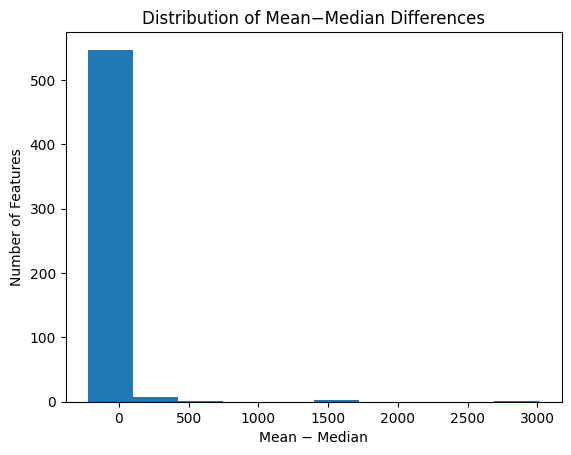

In [402]:
stats = pd.DataFrame({
    'mean': data_cleaned.mean(),
    'median': data_cleaned.median()
})
stats['mean_minus_median'] = stats['mean'] - stats['median']

plt.hist(stats['mean_minus_median'])
plt.xlabel('Mean − Median')
plt.ylabel('Number of Features')
plt.title('Distribution of Mean−Median Differences')
plt.show()

From this plot, it can be observed that Mean–median difference analysis across all features shows that most columns have Mean > Median, with a long positive tail. This confirms positive skewness and outlier influence, making mean imputation unsuitable 

In [403]:
# Median imputation for numerical features
num_cols = data_cleaned.select_dtypes(include=np.number).columns
num_cols = num_cols.drop('Pass/Fail')

data_cleaned[num_cols] = data_cleaned[num_cols].fillna(
    data_cleaned[num_cols].median()
)
print(f"Total null values: ")
data_cleaned[num_cols].isnull().sum().sum()


Total null values: 


np.int64(0)

In [404]:
data_cleaned['Pass/Fail'] = data_cleaned['Pass/Fail'].map({-1: 0, 1: 1})
print("Value counts of 'Pass/Fail' after remapping:")
print(data_cleaned['Pass/Fail'].value_counts(normalize=True))

Value counts of 'Pass/Fail' after remapping:
Pass/Fail
0    0.933631
1    0.066369
Name: proportion, dtype: float64


# Data analysis & visualisation

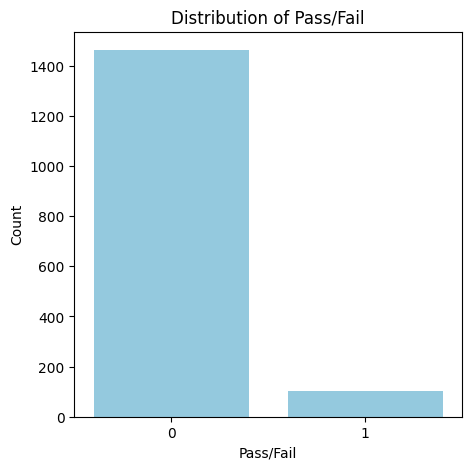

In [405]:
# Univariate Analysis of the Target
plt.figure(figsize=(5, 5))
sns.countplot(x='Pass/Fail', data=data_cleaned, color='skyblue')
plt.xlabel('Pass/Fail')
plt.ylabel('Count')
plt.title('Distribution of Pass/Fail')
plt.show()

The target variable is imbalanced, with Pass class dominating. 

In [406]:
print(f"Detailed statistical summary:")
data_cleaned.describe()

Detailed statistical summary:


,0,1,2,3,4,5,6,7,8,9,...,577,582,583,584,585,586,587,588,589,Pass/Fail
count,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.0,1567.000000,1567.000000,1567.000000,1567.000000,...,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000
mean,3014.441551,2495.866110,2200.551958,1395.383474,4.171281,100.0,101.116476,0.121825,1.462860,-0.000842,...,16.642363,0.500096,0.015317,0.003846,3.067628,0.021458,0.016474,0.005283,99.652345,0.066369
std,73.480841,80.228143,29.380973,439.837330,56.103721,0.0,6.209385,0.008936,0.073849,0.015107,...,12.485267,0.003403,0.017174,0.003719,3.576899,0.012354,0.008805,0.002866,93.864558,0.249005
min,2743.240000,2158.750000,2060.660000,0.000000,0.681500,100.0,82.131100,0.000000,1.191000,-0.053400,...,4.582000,0.477800,0.006000,0.001700,1.197500,-0.016900,0.003200,0.001000,0.000000,0.000000
25%,2966.665000,2452.885000,2181.099950,1083.885800,1.017700,100.0,97.937800,0.121100,1.411250,-0.010800,...,11.501550,0.497900,0.011600,0.003100,2.306500,0.013450,0.010600,0.003300,44.368600,0.000000
50%,3011.490000,2499.405000,2201.066700,1285.214400,1.316800,100.0,101.512200,0.122400,1.461600,-0.001300,...,13.817900,0.500200,0.013800,0.003600,2.757650,0.020500,0.014800,0.004600,71.900500,0.000000
75%,3056.540000,2538.745000,2218.055500,1590.169900,1.518800,100.0,104.530000,0.123800,1.516850,0.008400,...,17.080900,0.502350,0.016500,0.004100,3.294950,0.027600,0.020300,0.006400,114.749700,0.000000
max,3356.350000,2846.440000,2315.266700,3715.041700,1114.536600,100.0,129.252200,0.128600,1.656400,0.074900,...,96.960100,0.509800,0.476600,0.104500,99.303200,0.102800,0.079900,0.028600,737.304800,1.000000


Many sensor features have large differences between mean and median. High std deviations indicate presence of outliers

#  Data pre-processing

In [407]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.0)
selector.fit(data_cleaned.drop('Pass/Fail', axis=1))

constant_cols = data_cleaned.drop('Pass/Fail', axis=1).columns[~selector.get_support()]
data_cleaned.drop(columns=constant_cols, inplace=True)


Constant features provide no discriminatory power and were removed.

In [408]:
X = data_cleaned.drop('Pass/Fail', axis=1)
y = data_cleaned['Pass/Fail']

# Model training, testing and tuning

In [409]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [410]:
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

SMOTE applied before cross-validation to ensure balanced class distribution across training folds while preventing test data leakage

## Model 1: Random Forest (Powerful for Sensors)

In [411]:
rf = RandomForestClassifier(random_state=42)

param_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20]
}

grid_rf = GridSearchCV(rf, param_rf, cv=5, scoring='f1', n_jobs=-1)
grid_rf.fit(X_train_sm, y_train_sm)

y_pred_rf = grid_rf.predict(X_test)

print("Random Forest")
print(classification_report(y_test, y_pred_rf))


Random Forest
              precision    recall  f1-score   support

           0       0.93      1.00      0.97       293
           1       0.00      0.00      0.00        21

    accuracy                           0.93       314
   macro avg       0.47      0.50      0.48       314
weighted avg       0.87      0.93      0.90       314



In [412]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_sm)
X_test_scaled = scaler.transform(X_test)


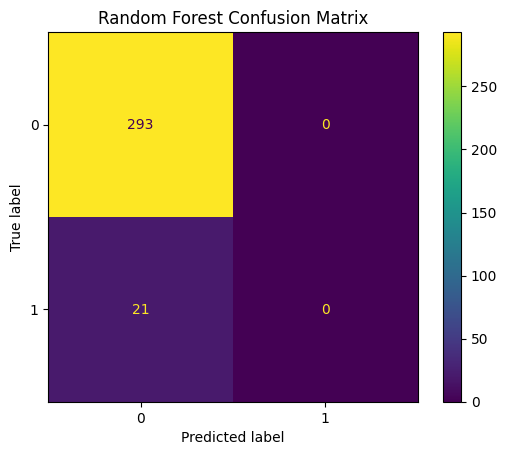

In [413]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)
plt.title("Random Forest Confusion Matrix")
plt.show()


# Model 2: Logistic Regression

In [414]:
lr = LogisticRegression(max_iter=1000)

param_lr = {
    'C': [0.01, 0.1, 1, 10]
}

grid_lr = GridSearchCV(lr, param_lr, cv=5, scoring='f1')
grid_lr.fit(X_train_scaled, y_train_sm)

y_pred_lr = grid_lr.predict(X_test_scaled)

print("Logistic Regression")
print(classification_report(y_test, y_pred_lr))

Logistic Regression
              precision    recall  f1-score   support

           0       0.94      0.89      0.91       293
           1       0.09      0.14      0.11        21

    accuracy                           0.84       314
   macro avg       0.51      0.52      0.51       314
weighted avg       0.88      0.84      0.86       314



# Model 3: Support Vector Machine

In [415]:
svm = SVC()

param_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf']
}

grid_svm = GridSearchCV(svm, param_svm, cv=5, scoring='f1')
grid_svm.fit(X_train_scaled, y_train_sm)

y_pred_svm = grid_svm.predict(X_test_scaled)

print("SVM")
print(classification_report(y_test, y_pred_svm))

SVM
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       293
           1       1.00      0.05      0.09        21

    accuracy                           0.94       314
   macro avg       0.97      0.52      0.53       314
weighted avg       0.94      0.94      0.91       314



In [416]:
from sklearn.metrics import f1_score, accuracy_score

results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'SVM'],
    'Test Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_svm)
    ],
    'Test F1-score': [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_svm)
    ]
})

results.sort_values(by='Test F1-score', ascending=False)
results

,Model,Test Accuracy,Test F1-score
0,Logistic Regression,0.840764,0.107143
1,Random Forest,0.933121,0.000000
2,SVM,0.936306,0.090909


In [417]:
# Best overall model: Random Forest
joblib.dump(grid_rf.best_estimator_, "final_yield_model.pkl")

# Scaler used only for LR & SVM
joblib.dump(scaler, "scaler_lr_svm.pkl")


['scaler_lr_svm.pkl']

RESULT: While SVM and Random Forest achieved high accuracy, low F1-scores indicate difficulty predicting the minority class, highlighting class imbalance as a key challenge.